In [17]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mstamp_stamp import mstamp
from mstamp_stomp import mstamp as mstamp_stomp
from mstamp_RMSEs import compute_mstamp_RMSEs
from bits_compression import MDL
from demo import plot_motifs

In [18]:
def plot_motifs(matrix_profile, data, sub_len, dimensionality=None):
    motif_at = matrix_profile[dimensionality - 1, :].argsort()[:2]

    nb_dims, length = data.shape
    plt.figure(figsize=(20, 10))
    for i in range(nb_dims):
        plt.subplot(nb_dims+1,1,i+1)
        plt.plot(data[i])
        plt.title(f"$T_{i+1}$")
        for m in motif_at:
            plt.plot(range(m,m+sub_len), data[i][m:m+sub_len], c='r')
        # plt.xlim((0, matrix_profile.shape[1]))
        plt.xlim((0, length))

    plt.subplot(nb_dims+1, 1, nb_dims+1)
    plt.title('{}-dimensional Matrix Profile'.format(dimensionality))
    plt.plot(matrix_profile[dimensionality-1, :])
    for m in motif_at:
        plt.axvline(m, c='r')
    # plt.xlim((0, matrix_profile.shape[1]))
    plt.xlim((0, length))
    plt.tight_layout()


# First dataset

This dataset relate returns of Istanbul Stock Exchange with
several other international indices,
from Jun 5, 2009 to Feb 22, 2011, and is organized with regard to working days in Istanbul Stock Exchange.

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


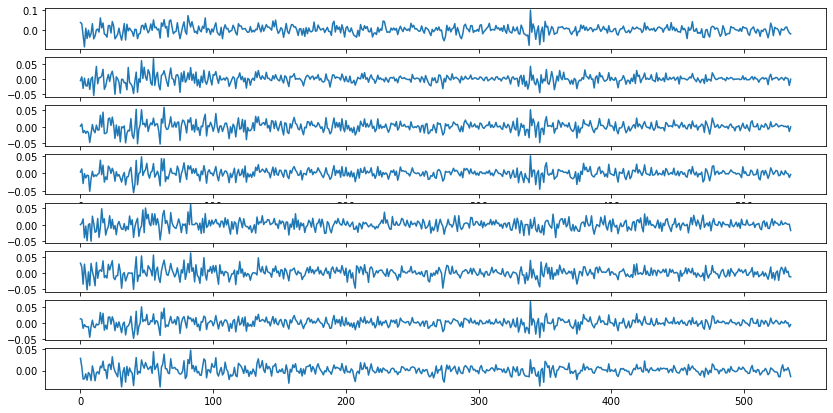

In [19]:
data = pd.read_excel("data_akbilgic.xlsx")
data_copy = data.drop(columns=["Unnamed: 0", "TL BASED"], index=[0])
time_series = data_copy.to_numpy().transpose(1,0)

nb_dims = time_series.shape[0]
fig, axs =  plt.subplots(nb_dims, 1, figsize=(14,7))
for i in range(nb_dims):
    axs[i].plot(time_series[i])
plt.show()

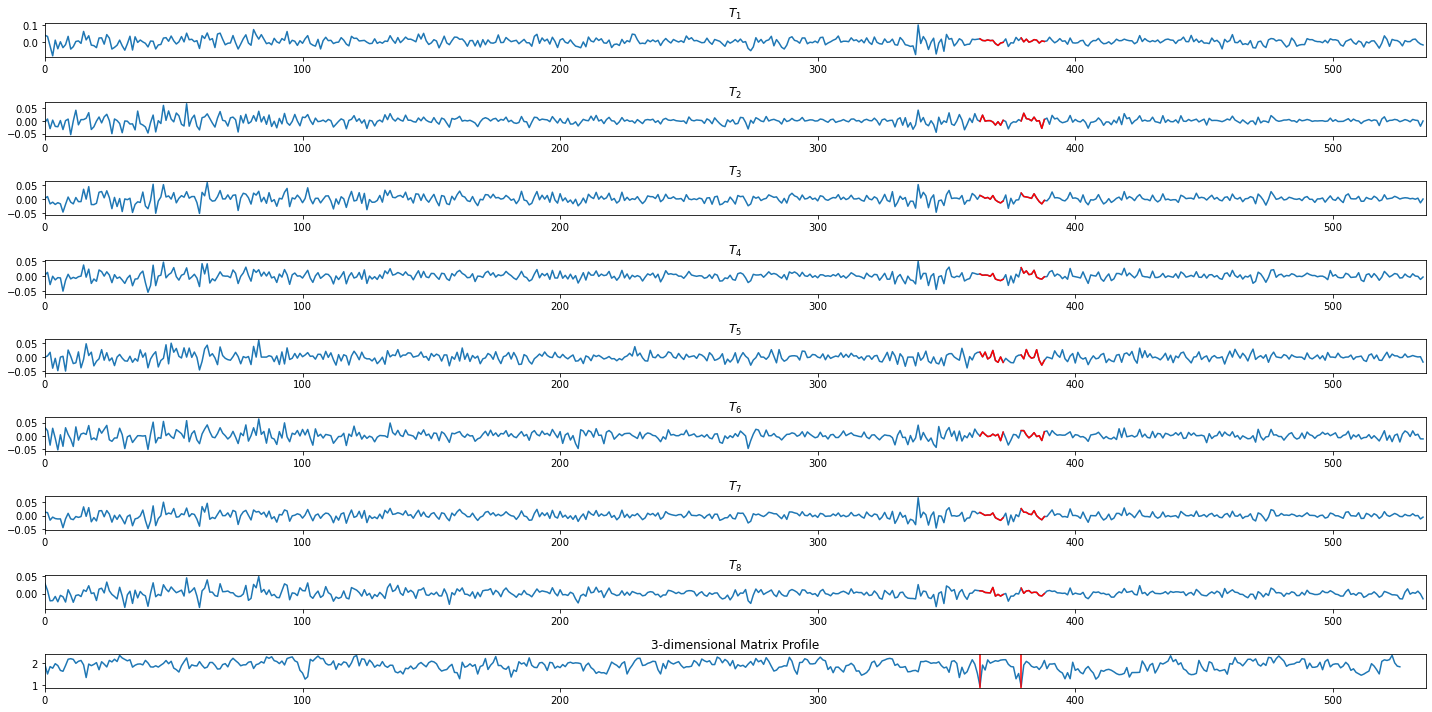

In [26]:
# plot the matrix profil for three dimension
sub_len = 10
mat_pro_approx, pro_idx_approx = mstamp(time_series, sub_len, return_dimension=False)
plot_motifs(mat_pro_approx, time_series, sub_len, 3)

# Second dataset

This dataset contains historical stock data for 30 DJIA companies as well as the total stock, from 2006-01-01 to 2018-01-01.

In [21]:
all_data = pd.read_csv("DJIA_30_Stock/all_stocks_2006-01-01_to_2018-01-01.csv")
names = list(set(all_data["Name"].tolist()))

length = 3019
dims = len(names)
final_data = np.zeros((dims, length))
lens = []
for k, name in enumerate(names):
    data = np.array(all_data[all_data["Name"] == name]["Open"].tolist())
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    assert np.any(~np.isnan(data))
    lens.append(len(data))
    final_data[k] = data[:length].copy()

data = final_data

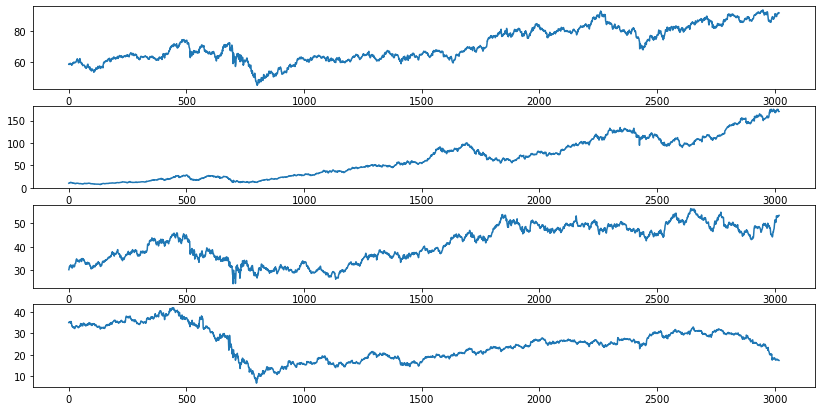

In [22]:
nb_dims_to_show = 4
fig, axs =  plt.subplots(nb_dims_to_show, 1, figsize=(14,7))
for i in range(nb_dims_to_show):
    axs[i].plot(data[i])
plt.show()

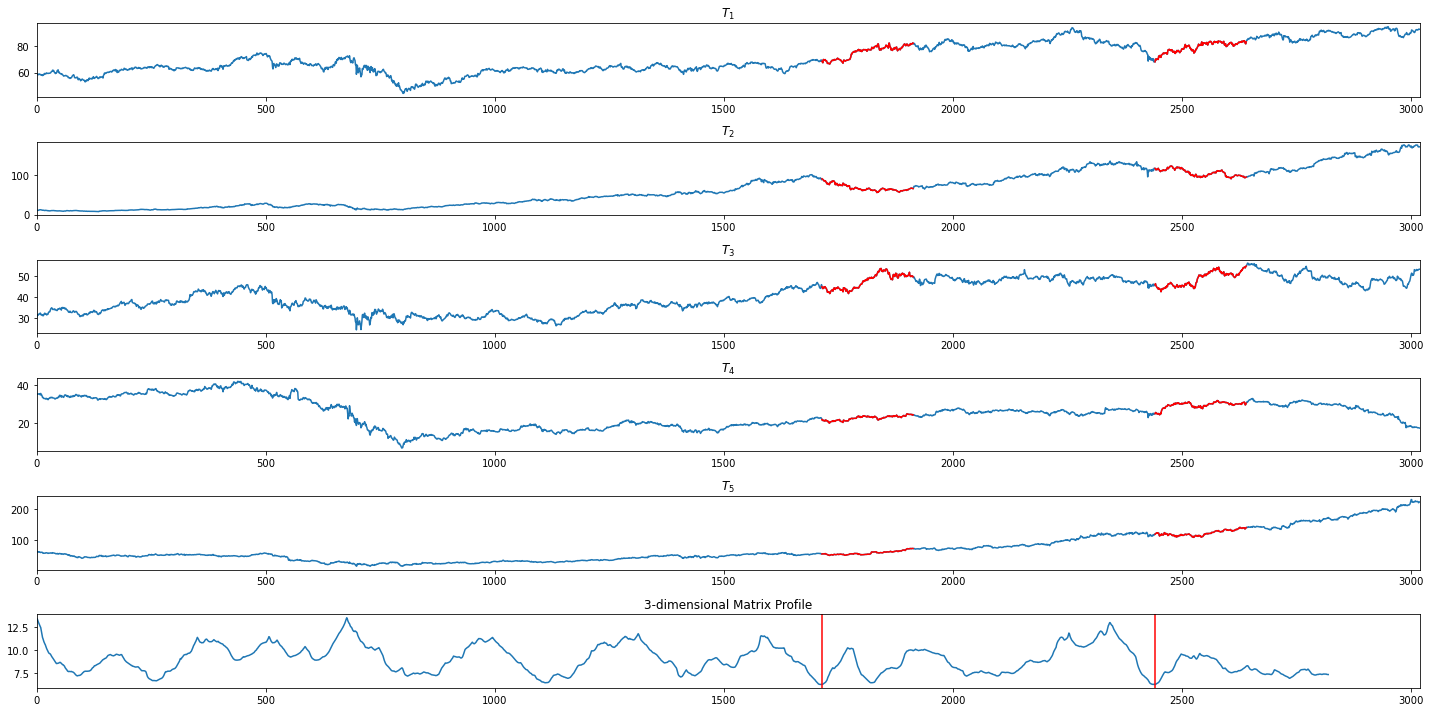

In [23]:
# plot the matrix profil for three dimension
# use only the first five dimensions of the data
nb_used_dims = 5
sub_len = 200
mat_pro_approx, pro_idx_approx = mstamp(data[:nb_used_dims], sub_len, return_dimension=False)
plot_motifs(mat_pro_approx, data[:nb_used_dims], sub_len, 3)

# Evolution of the RMSEs throughout the iterations

In [76]:
data = pd.read_excel("data_akbilgic.xlsx")
data_copy = data.drop(columns=["Unnamed: 0", "TL BASED"], index=[0])

time_series = data_copy.to_numpy().transpose(1,0)

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


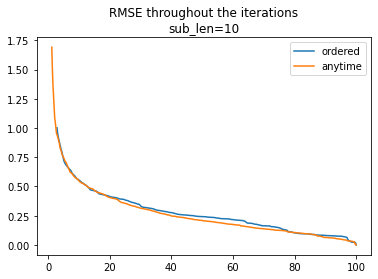

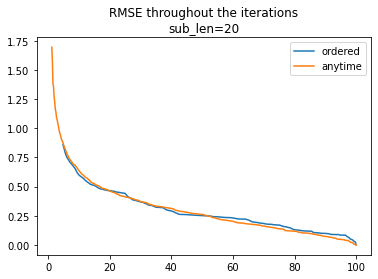

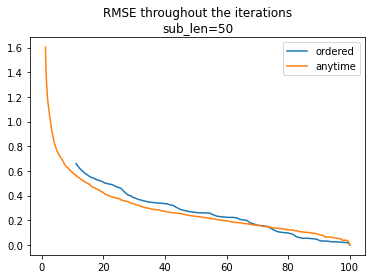

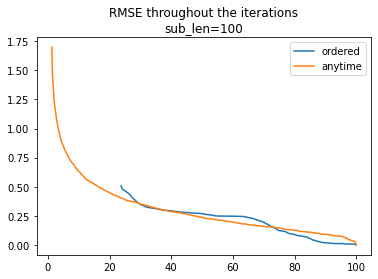

In [114]:
sub_len = 10
for sub_len in [10, 20, 50, 100]:
    iter_10perc = int(0.1*length-sub_len+1)
    mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
    RMSEs = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=False)
    RMSEs_anytime = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=True)
    # mat_pro_10perc, _ =  mstamp(time_series, sub_len, iter=iter_10perc, random=True)

    length = time_series.shape[1]
    perc_iters = np.linspace(1,100,length-sub_len+1)
    max_val = max([RMSEs[RMSEs < np.inf].max(),
                RMSEs_anytime[RMSEs_anytime < np.inf].max()])
    plt.figure()
    plt.title(f"RMSE throughout the iterations\nsub_len={sub_len}")
    plt.plot(perc_iters, RMSEs)
    plt.plot(perc_iters, RMSEs_anytime)
    plt.legend(["ordered", "anytime"])
    plt.show()

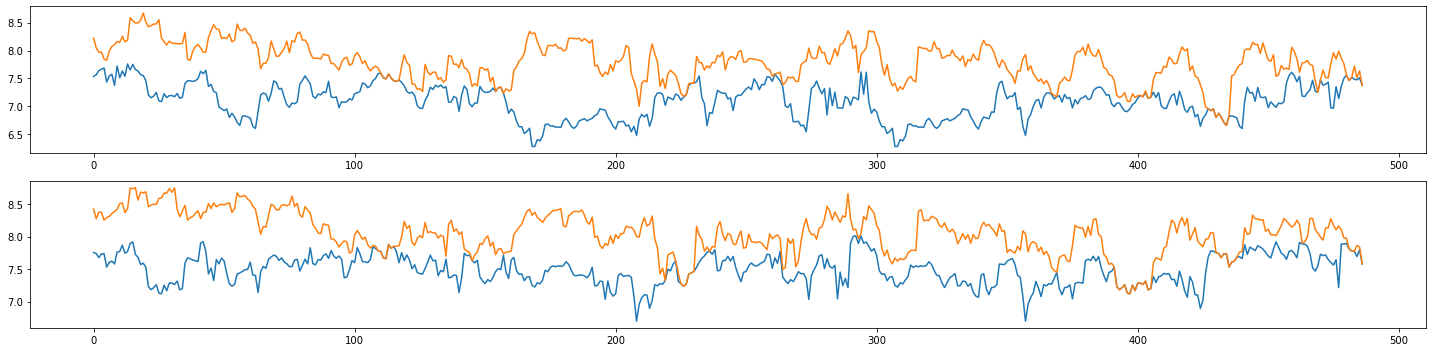

In [115]:
sub_len = 50
length = time_series.shape[1]
iter_10perc = int(0.2*length-sub_len+1)
mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
RMSEs = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=True)
mat_pro_10perc, _ =  mstamp(time_series, sub_len, iter=iter_10perc, random=True)

plt.figure(figsize=(20,5))
for d in range(2):
    plt.subplot(2, 1, d+1)
    plt.plot(mat_pro_ref[d])
    plt.plot(mat_pro_10perc[d])
plt.tight_layout()
plt.show()

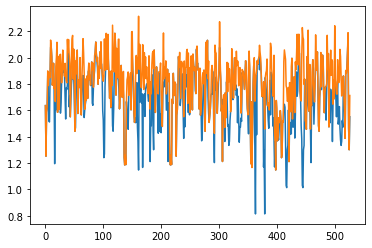

In [96]:
plt.plot(mat_pro_ref[1])
plt.plot(mat_pro_10perc[1])

In [80]:
all_data = pd.read_csv("DJIA_30_Stock/all_stocks_2006-01-01_to_2018-01-01.csv")
names = list(set(all_data["Name"].tolist()))

length = 3019
dims = len(names)
final_data = np.zeros((dims, length))
lens = []
for k, name in enumerate(names):
    data = np.array(all_data[all_data["Name"] == name]["Open"].tolist())
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    assert np.any(~np.isnan(data))
    lens.append(len(data))
    final_data[k] = data[:length].copy()

data = final_data

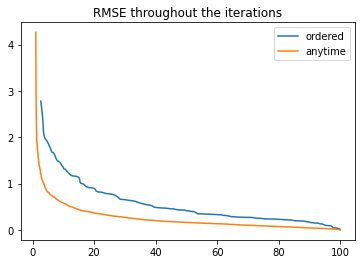

In [106]:
sub_len = 50
nb_used_dims = 2
length = data.shape[1]

iter_10perc = int(0.1*length-sub_len+1)
mat_pro_ref, pro_idx_ref = mstamp(data[:nb_used_dims], sub_len)
RMSEs = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=True)
mat_pro_10perc, _ =  mstamp(data[:nb_used_dims], sub_len, iter=iter_10perc, random=True)

perc_iters = np.linspace(1,100,length-sub_len+1)
max_val = max([RMSEs[RMSEs < np.inf].max(),
               RMSEs_anytime[RMSEs_anytime < np.inf].max()])
plt.figure()
plt.title("RMSE throughout the iterations")
plt.plot(perc_iters, RMSEs)
plt.plot(perc_iters, RMSEs_anytime)
plt.legend(["ordered", "anytime"])
plt.show()

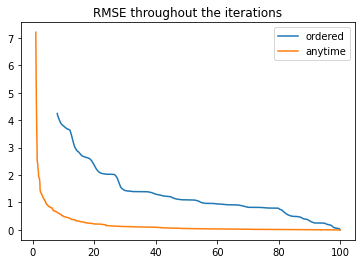

In [116]:
sub_len = 200
nb_used_dims = 3
length = data.shape[1]

iter_20perc = int(0.2*length-sub_len+1)
mat_pro_ref, pro_idx_ref = mstamp(data[:nb_used_dims], sub_len)
RMSEs = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=True)
mat_pro_20perc, _ =  mstamp(data[:nb_used_dims], sub_len, iter=iter_20perc, random=True)

perc_iters = np.linspace(1,100,length-sub_len+1)
max_val = max([RMSEs[RMSEs < np.inf].max(),
               RMSEs_anytime[RMSEs_anytime < np.inf].max()])
plt.figure()
plt.title("RMSE throughout the iterations")
plt.plot(perc_iters, RMSEs)
plt.plot(perc_iters, RMSEs_anytime)
plt.legend(["ordered", "anytime"])
plt.show()

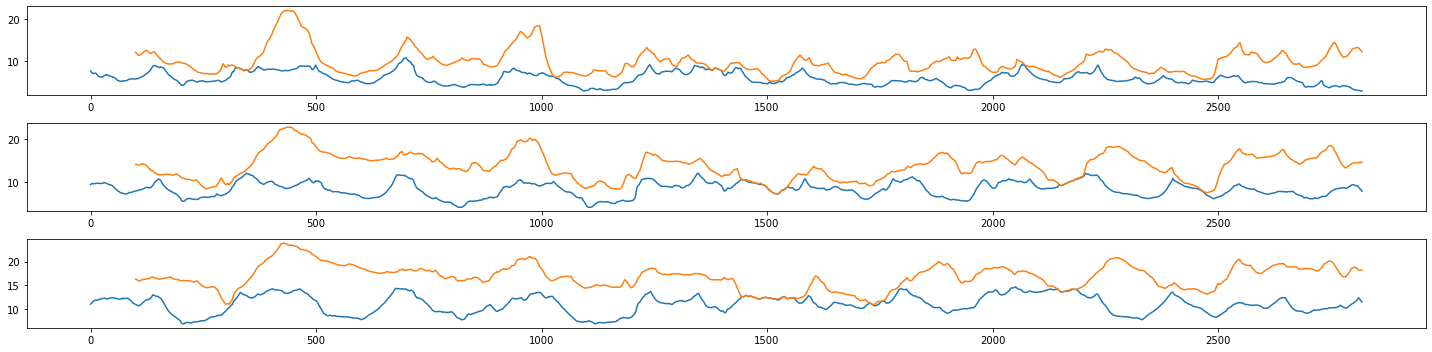

In [122]:
iter = int(0.1*length-sub_len+1)
mat_pro_approx, _ =  mstamp(data[:nb_used_dims], sub_len, iter=iter, random=True)
plt.figure(figsize=(20,5))
for d in range(3):
    plt.subplot(3, 1, d+1)
    plt.plot(mat_pro_ref[d])
    plt.plot(mat_pro_approx[d])
plt.tight_layout()
plt.show()

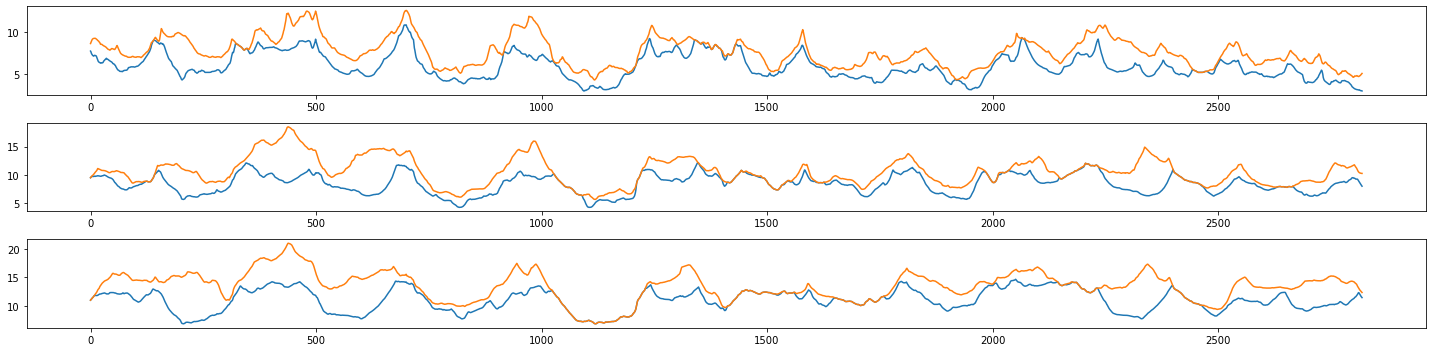

In [121]:
iter = int(0.2*length-sub_len+1)
mat_pro_approx, _ =  mstamp(data[:nb_used_dims], sub_len, iter=iter, random=True)
plt.figure(figsize=(20,5))
for d in range(3):
    plt.subplot(3, 1, d+1)
    plt.plot(mat_pro_ref[d])
    plt.plot(mat_pro_approx[d])
plt.tight_layout()
plt.show()

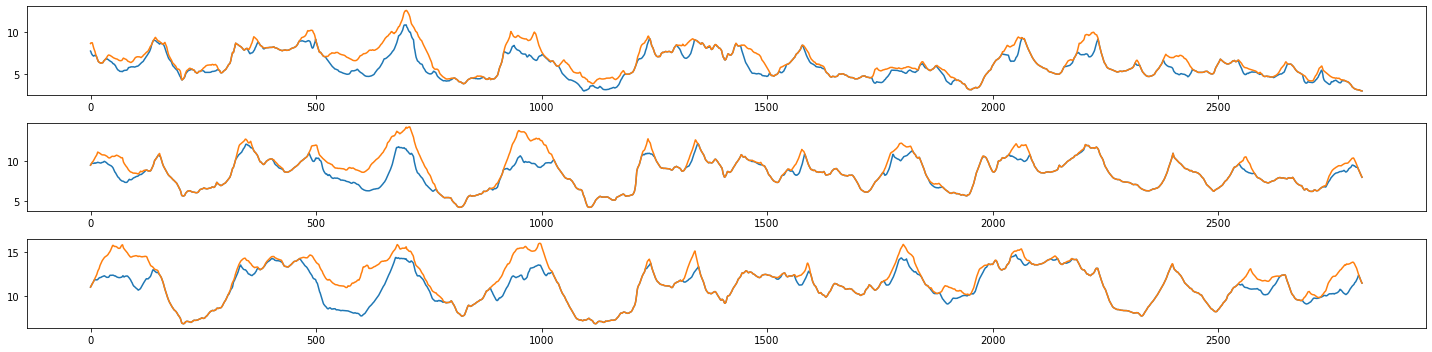

In [119]:
iter = int(0.5*length-sub_len+1)
mat_pro_approx, _ =  mstamp(data[:nb_used_dims], sub_len, iter=iter, random=True)
plt.figure(figsize=(20,5))
for d in range(3):
    plt.subplot(3, 1, d+1)
    plt.plot(mat_pro_ref[d])
    plt.plot(mat_pro_approx[d])
plt.tight_layout()
plt.show()

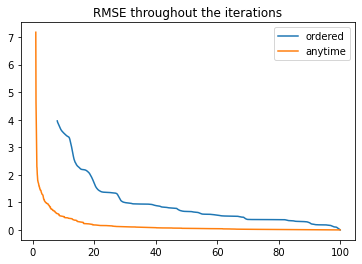

In [81]:
sub_len = 200
nb_used_dims = 5

mat_pro_ref, pro_idx_ref = mstamp(data[:nb_used_dims], sub_len)
RMSEs = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=True)

length = data.shape[1]
perc_iters = np.linspace(1,100,length-sub_len+1)
max_val = max([RMSEs[RMSEs < np.inf].max(),
               RMSEs_anytime[RMSEs_anytime < np.inf].max()])
plt.figure()
plt.title("RMSE throughout the iterations")
plt.plot(perc_iters, RMSEs)
plt.plot(perc_iters, RMSEs_anytime)
plt.legend(["ordered", "anytime"])
plt.show()

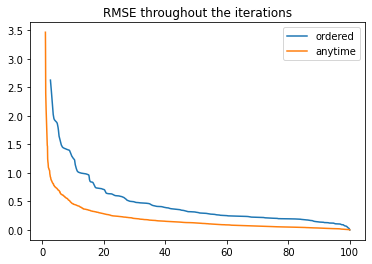

In [82]:
sub_len = 50
nb_used_dims = 5

mat_pro_ref, pro_idx_ref = mstamp(data[:nb_used_dims], sub_len)
RMSEs = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=True)

length = data.shape[1]
perc_iters = np.linspace(1,100,length-sub_len+1)
max_val = max([RMSEs[RMSEs < np.inf].max(),
               RMSEs_anytime[RMSEs_anytime < np.inf].max()])
plt.figure()
plt.title("RMSE throughout the iterations")
plt.plot(perc_iters, RMSEs)
plt.plot(perc_iters, RMSEs_anytime)
plt.legend(["ordered", "anytime"])
plt.show()

In [ ]:
sub_len = 50
nb_used_dims = 5

mat_pro_ref, pro_idx_ref = mstamp(data[:nb_used_dims], sub_len)
RMSEs = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(data[:nb_used_dims], sub_len, mat_pro_ref, random=True)

length = data.shape[1]
perc_iters = np.linspace(1,100,length-sub_len+1)
max_val = max([RMSEs[RMSEs < np.inf].max(),
               RMSEs_anytime[RMSEs_anytime < np.inf].max()])
plt.figure()
plt.title("RMSE throughout the iterations")
plt.plot(perc_iters, RMSEs)
plt.plot(perc_iters, RMSEs_anytime)
plt.legend(["ordered", "anytime"])
plt.show()

# Running time depending on the subsequence length

100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


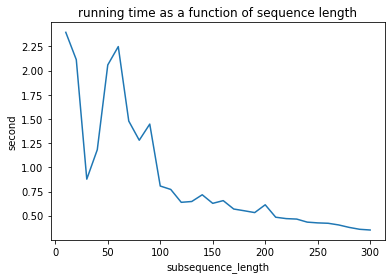

In [124]:
max_subsequence_length = 300
subsequence_length = np.arange(10, max_subsequence_length+1, 10)
sec = []
for sub in tqdm(subsequence_length):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(time_series, sub)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(subsequence_length, sec)
plt.title("running time as a function of sequence length")
plt.xlabel("subsequence_length")
plt.ylabel("seconds")
plt.show()

100%|██████████| 6/6 [02:18<00:00, 23.12s/it]


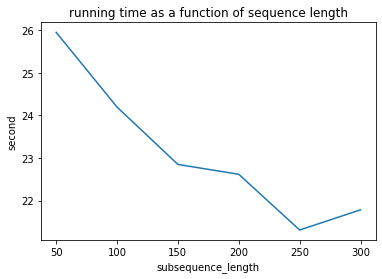

In [125]:
nb_used_dims = 5
max_subsequence_length = 301
subsequence_length = np.arange(50, max_subsequence_length+1, 50)
sec = []
for sub in tqdm(subsequence_length):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(data[:nb_used_dims], sub)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(subsequence_length, sec)
plt.title("running time as a function of sequence length")
plt.xlabel("subsequence_length")
plt.ylabel("seconds")
plt.show()

# Running time depending on the time series length

100%|██████████| 12/12 [01:11<00:00,  5.92s/it]


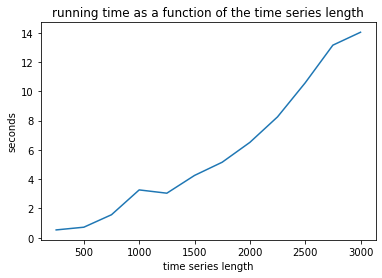

In [135]:
nb_used_dims = 10
lengths = np.arange(250, 3001, 250)
sec = []
sub_len = 20
for length in tqdm(lengths):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(data[:nb_used_dims,:length], sub_len)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(lengths, sec)
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.show()

# Comparison of the STAMP and STOMP versions of mSTAMP

Takes about 8 minutes to run

100%|██████████| 12/12 [08:06<00:00, 40.57s/it]


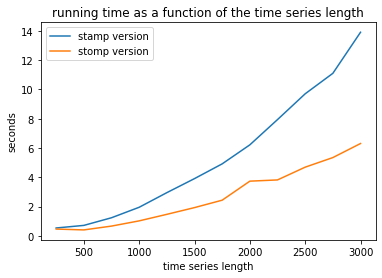

In [16]:
nb_used_dims = 10
lengths = np.arange(250, 3001, 250)
sec_stamp = []
sec_stomp = []
sub_len = 10

nb_simu = 5
for length in tqdm(lengths):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(data[:nb_used_dims,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stamp.append(mean_duration)
    
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp_stomp(data[:nb_used_dims,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stomp.append(mean_duration)
plt.plot(lengths, sec_stamp)
plt.plot(lengths, sec_stomp)
plt.legend(["stamp version", "stomp version"])
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.show()

Takes about 1 minute 30 to run

100%|██████████| 19/19 [01:27<00:00,  4.62s/it]


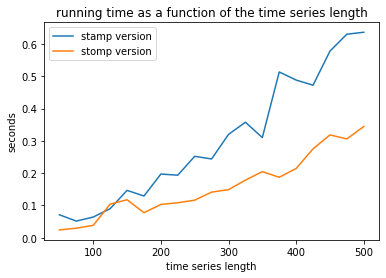

In [15]:
lengths = np.arange(50, 513, 25)
sec_stamp = []
sec_stomp = []
sub_len = 10

nb_simu = 10
for length in tqdm(lengths):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series[:,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stamp.append(mean_duration)
    
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp_stomp(time_series[:,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stomp.append(mean_duration)
plt.plot(lengths, sec_stamp)
plt.plot(lengths, sec_stomp)
plt.legend(["stamp version", "stomp version"])
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.show()

# Running time depending on the dimensionality

100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


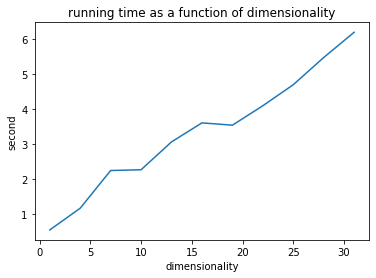

In [31]:
length = 1000
sub_len = 50
nb_dims_list = np.arange(1,32,3)
sec = []
for nb_dims in tqdm(nb_dims_list):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(data[:nb_dims,:length], sub_len)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(nb_dims_list, sec)
plt.title("running time as a function of dimensionality")
plt.xlabel("dimensionality")
plt.ylabel("seconds")
plt.show()

# MDL-based method

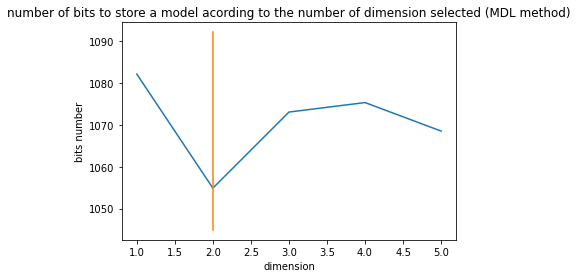

In [33]:
nb_dims = 5
length = 1000
sub_len = 50

mat_pro, pro_idx, profile = mstamp(data[:nb_dims,:length], sub_len, return_dimension=True)
bits = MDL(mat_pro, data[:nb_dims,:length].T, sub_len, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)

plt.plot(np.arange(nb_dims) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimension")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

In [ ]:
data = pd.read_excel("data_akbilgic.xlsx")
data_copy = data.drop(columns=["Unnamed: 0", "TL BASED"], index=[0])

time_series = data_copy.to_numpy()
fig, axs =  plt.subplots(8, 1, figsize=(14,7))
for i in range(8):
    axs[i].plot(time_series[:, i])
plt.show()

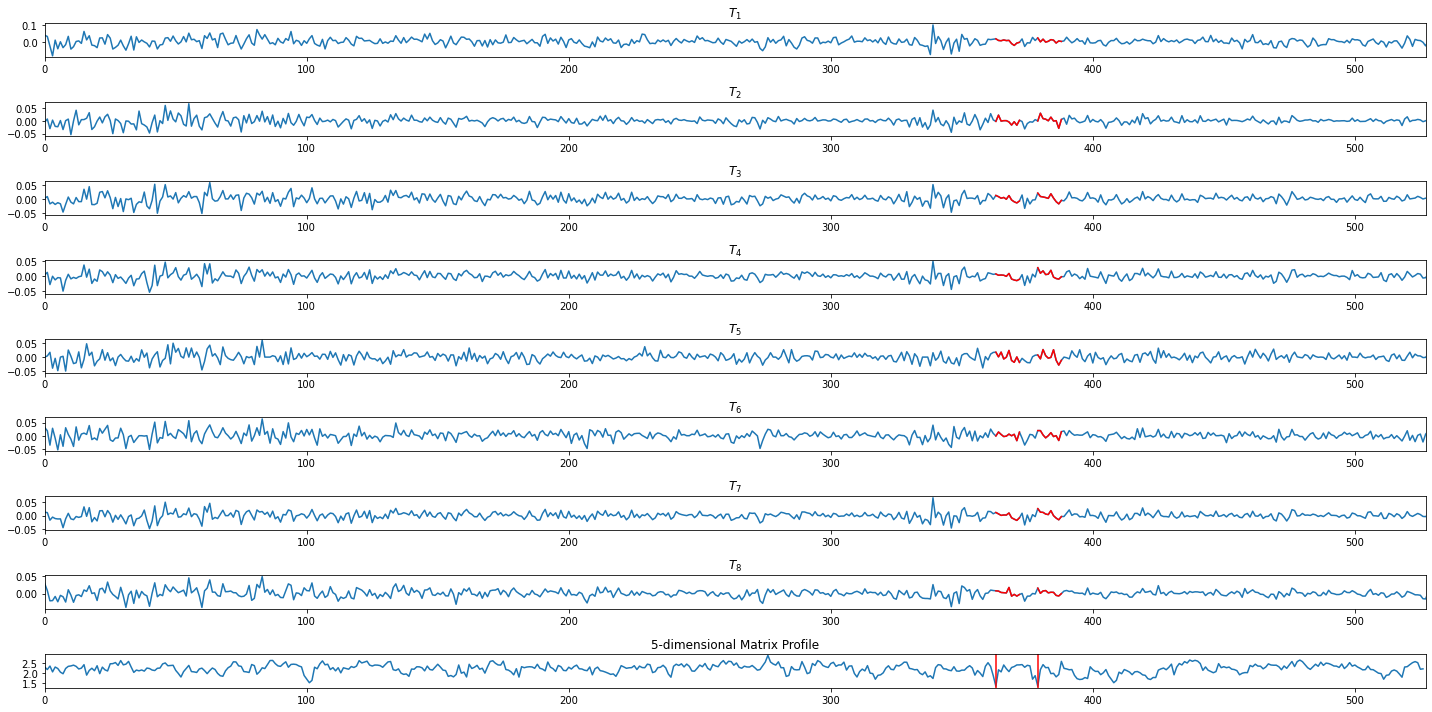

In [11]:
# plot the matrix profil for best dimension dimension

mat_pro_approx, pro_idx_approx = mstamp(time_series.T, 10, return_dimension=False)
plot_motifs(mat_pro_approx, time_series, 10, argmin)

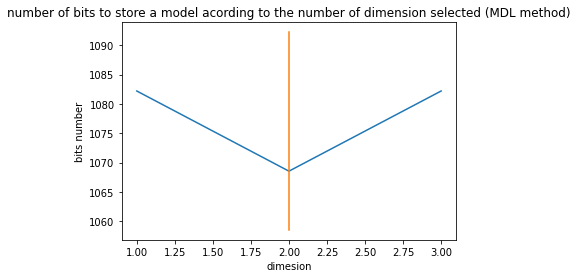

In [12]:
import scipy.io as sio

mat = sio.loadmat('toy_data.mat')
data = mat['data']
sub_len = mat['sub_len'][0][0]

mat_pro, pro_idx, profile = mstamp(data.T, sub_len, return_dimension=True)
bits = MDL(mat_pro, data, 50, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)
plt.plot(np.arange(3) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimension")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

In [ ]:
t_c = np.array([[1, 3, 4, 5, 4, 3, 6, 15, 14, 13, 12, 0, 2, 4, 2, 6, 10, 11, 9, 3]])
t_h = np.array([[1, 3, 3, 5, 4, 3, 6, 15, 14, 13, 12, 0, 2, 3, 2, 6, 4, 3, 1, 0]])
RDL(t_c, t_h, h=2)